# Import libraries and modules

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from stock_LSTM import StockLSTM
from dataset_creation import StockDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Load Dataset

In [2]:
base_path = "price/raw"
df = pd.read_csv(f"{base_path}/AAPL.csv")
print(len(df))

1258


In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [16]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,0.362825,0.364963,0.367482,0.375340,87.121140,0.227562
1,2012-09-05,0.375638,0.366566,0.374189,0.369085,86.509338,0.205288
2,2012-09-06,0.372504,0.369136,0.375768,0.377055,87.288956,0.244032
3,2012-09-07,0.378878,0.374685,0.382305,0.382558,87.827171,0.200546
4,2012-09-10,0.382012,0.375758,0.364325,0.359201,85.542564,0.312446


# Prepare dataset

In [24]:
feature_columns = ['Open','High','Low','Close','Volume']
# feature_columns = ['Close']
filtered_df = df[feature_columns]
seq_len = 4
train_size = int(len(filtered_df) * 0.8)
train_data = filtered_df.iloc[:train_size]
test_data = filtered_df.iloc[train_size:]


In [25]:
try:
    train_dataset = StockDataset(train_data, seq_len, feature_columns)
    test_dataset = StockDataset(test_data, seq_len, feature_columns)
    print("Datasets created successfully!")
except Exception as e:
    print(f"Error creating dataset: {e}")

Datasets created successfully!


In [26]:
train_dataset[0]

(tensor([[0.3628, 0.3650, 0.3675, 0.3753, 0.2276],
         [0.3756, 0.3666, 0.3742, 0.3691, 0.2053],
         [0.3725, 0.3691, 0.3758, 0.3771, 0.2440],
         [0.3789, 0.3747, 0.3823, 0.3826, 0.2005]]),
 tensor(0.3592))

In [27]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Model initialization

In [45]:
input_size = len(feature_columns)
hidden_size = 128
num_layers = 3

model = StockLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [43]:
epochs = 50
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Test the model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().numpy())
        actuals.extend(targets.numpy())

Epoch 1/50, Loss: 0.009544508531689644
Epoch 2/50, Loss: 0.0008745969389565289
Epoch 3/50, Loss: 0.0020320711191743612
Epoch 4/50, Loss: 0.000759194721467793
Epoch 5/50, Loss: 0.0008890377357602119
Epoch 6/50, Loss: 0.0007490693824365735
Epoch 7/50, Loss: 0.0004886604729108512
Epoch 8/50, Loss: 6.669204594800249e-05
Epoch 9/50, Loss: 0.00019619576050899923
Epoch 10/50, Loss: 0.00020372201106511056
Epoch 11/50, Loss: 0.00048692175187170506
Epoch 12/50, Loss: 0.0008879567612893879
Epoch 13/50, Loss: 0.0009778542444109917
Epoch 14/50, Loss: 0.0005970185738988221
Epoch 15/50, Loss: 0.00036651999107562006
Epoch 16/50, Loss: 0.0005159220891073346
Epoch 17/50, Loss: 0.0005351532017812133
Epoch 18/50, Loss: 0.0002583533641882241
Epoch 19/50, Loss: 0.0004406780353747308
Epoch 20/50, Loss: 0.0006025167531333864
Epoch 21/50, Loss: 0.0009264739928767085
Epoch 22/50, Loss: 0.0005570483626797795
Epoch 23/50, Loss: 0.0007057121256366372
Epoch 24/50, Loss: 0.00028912650304846466
Epoch 25/50, Loss: 0.0

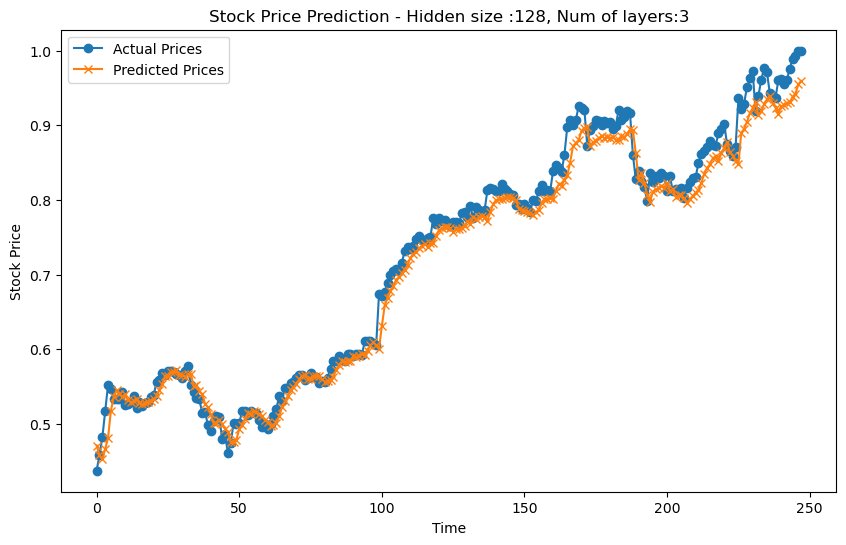

In [48]:
# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Prices', marker='o')
plt.plot(predictions, label='Predicted Prices', marker='x')
plt.title(f'Stock Price Prediction - Hidden size :{hidden_size}, Num of layers:{ num_layers}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
